In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function

Import list of all minor planet discoveries from MPC and list of all minor planets from the MPC `MPCORB.DAT` file, using the same data set as Granvik 2016, 2017, 2018:

In [2]:
# list of minor planet discoveries from the MPC
discovery_data = pd.read_json('numberedmps.json').T
# list of all minor planets from the MPC:
all_mps = pd.read_json('mpcorb_extended.json')

# all_neos = pd.read_csv('all_17_25_neos.csv')

Filtering list of minor planet discoveries to only consider discoveries made by CSS between $2005$ and $2012$:

In [3]:
# Discoverers are 'CSS' or 'Catalina Sky Survey' and discovery date is between January 1, 2005 and December 31, 2012
css_discoveries = discovery_data[((discovery_data.Discoverers == 'CSS') | (discovery_data.Discoverers == 'Catalina Sky Survey')) 
& ('2005-01-01' < discovery_data.Discovery_date) & (discovery_data.Discovery_date < '2012-12-31')]
# reset index since it's actually the minor planet number
css_discoveries['mp_number'] = css_discoveries.index.astype(str)
css_discoveries.reset_index(drop=True, inplace=True)
# convert Name from nan to empty string
css_discoveries = css_discoveries.fillna('')
# make full name column by combining the number, name (if it has one) and principal designation
css_discoveries['full_name'] = css_discoveries.mp_number + css_discoveries.Name + ' (' + css_discoveries.Principal_desig + ')'
css_discoveries['mp_number'] = '(' + css_discoveries.mp_number + ')'

/tmp/ipykernel_31782/1264834492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  css_discoveries['mp_number'] = css_discoveries.index.astype(str)


In [4]:
np.min(css_discoveries.Discovery_date), np.max(css_discoveries.Discovery_date)

('2005-01-06', '2012-12-21')

Now filter list of minor planets to only include the ones discovered by CSS and be NEOs ($q < 1.3$ AU):

In [5]:
all_mps['q'] = (all_mps.a * (1. - all_mps.e))
# filter for NEOs
all_neos = all_mps[all_mps.q < 1.3]
# filter for CSS neos
css_neos = all_neos[all_neos.Number.isin(css_discoveries.mp_number)]

Now filter list of NEOs to only include ones with $17 < H < 25$ and get their $q$s:

In [6]:
# filter for 17 < H < 25:
mag_limited_neos = css_neos[(17. < css_neos.H) & (css_neos.H < 25.)]
mag_limited_qs = mag_limited_neos.q

In [7]:
mag_limited_neos

,Critical_list_numbered_object_flag,H,G,Num_obs,rms,U,Arc_years,Perturbers,Perturbers_2,Number,...,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type,NEO_flag,One_km_NEO_flag,PHA_flag,One_opposition_object_flag,Arc_length,q
155109,NaN,17.49,0.15,866.0,0.63,0,1998-2022,M-v,3El,(155110),...,1.701011,0.554138,3.399326,Apollo,1.0,1.0,NaN,NaN,NaN,0.821883
155139,NaN,17.47,0.15,902.0,0.52,0,1982-2024,M-v,3Ek,(155140),...,2.386879,0.152041,3.277624,Apollo,1.0,1.0,NaN,NaN,NaN,0.162385
155337,NaN,20.40,0.15,126.0,0.69,1,2002-2007,M-v,3Ek,(155338),...,2.326453,0.601886,2.035515,Apollo,1.0,NaN,1.0,NaN,NaN,0.811949
172973,NaN,19.42,0.15,194.0,0.70,0,2002-2019,M-v,3Ek,(172974),...,2.040517,0.768668,1.913892,Amor,1.0,NaN,NaN,NaN,NaN,1.233228
212545,NaN,17.72,0.15,360.0,0.76,0,2003-2024,M-v,3Ek,(212546),...,3.231145,0.783130,1.473061,Amor,1.0,1.0,1.0,NaN,NaN,1.033657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620069,NaN,18.62,0.15,569.0,0.72,0,2004-2018,M-v,3Ek,(620070),...,3.546653,0.801738,1.405136,Amor,1.0,NaN,NaN,NaN,NaN,1.035911
620070,NaN,19.64,0.15,325.0,0.60,0,2011-2020,M-v,3Ek,(620071),...,2.260772,0.160631,3.921331,Apollo,1.0,NaN,1.0,NaN,NaN,0.172917
625787,NaN,19.35,0.15,115.0,0.69,0,2006-2020,M-v,3Ek,(625788),...,4.505407,0.841059,1.277040,Amor,1.0,NaN,NaN,NaN,NaN,1.034103
625990,NaN,21.41,0.15,108.0,0.83,0,2006-2023,M-v,3Ek,(625991),...,1.267671,0.315688,3.452523,Aten,1.0,NaN,NaN,NaN,NaN,0.420373


Importing the Monte Carlo cloned impactors and computing their $q$ (perihelion distance) values from $a$ and $e$:

$q = a\left(1 - e\right)$

In [8]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy file
a, e, i, peri, node, M = orb_param_array_all_events.T
# compute q from q = a * (1. - e)
impactor_qs = (a * (1. - e)).reshape(-1)

Plotting normalized histograms for the $q$ values of the cloned impactors and the CSS NEOs:

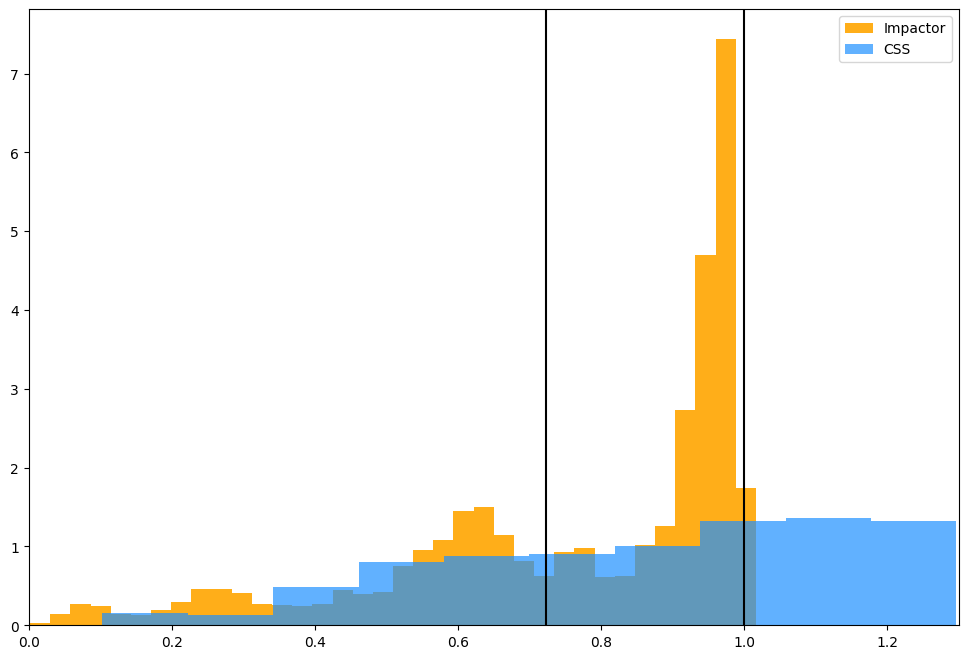

In [10]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs, bins='auto', color = 'orange', label = 'Impactor', density=True, alpha=0.9)
plt.hist(mag_limited_qs, bins='auto', color='dodgerblue', label = 'CSS', density=True, alpha=0.7)
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Compare using a K-S test and find the $p$-value:

In [12]:
import scipy.stats
scipy.stats.ks_2samp(impactor_qs, mag_limited_qs).pvalue

3.940264020924297e-34

Impactors do not appear to show the same bias as the CSS objects...